In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Context
This is the solution for the [Synthanic competition](https://www.kaggle.com/c/tabular-playground-series-apr-2021) on Kaggle.

The goal is to perform EDA and create a model solving binary classification task using [synthetic dataset](https://www.kaggle.com/c/tabular-playground-series-apr-2021/data) which is based on a real Titanic dataset. The statistical properties of this dataset are similar to the original Titanic dataset.

#### Data Dictionary
The DataFrame contains 100 000 entries with 11 parameters.

Variables description
- Survived: 1 - survived, 0 - died
- Pclass: ticket class
- SibSp: number of siblings/spouses aboard the Titanic
- Parch: number of parents/children aboard the Titanic
- Ticket: ticket number
- Fare: passenger fare
- Cabin: cabin number
- Embarked: port of embarkation, C = Cherbourg, Q = Queenstown, S = Southampton

#### Variable Notes
pclass: A proxy for socio-economic status (SES)
- 1st = Upper
- 2nd = Middle
- 3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
- Sibling = brother, sister, stepbrother, stepsister
- Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
- Parent = mother, father
- Child = daughter, son, stepdaughter, stepson
- Some children travelled only with a nanny, therefore parch=0 for them.

In [2]:
data = pd.read_csv('train.csv', index_col='PassengerId')
data.sample(10)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
50670,1,1,"Nelson, Lori",female,32.0,1,1,SC/Paris 38318,31.50,NaN,S
63689,0,3,"Berryman, Jim",male,5.0,0,0,A/5. 9331,11.71,NaN,S
11744,1,3,"Marker, Chester",male,60.0,0,0,20117,6.91,NaN,S
62172,0,3,"Evans, Marshall",male,36.0,0,0,SCO/W 35167,14.19,NaN,S
50361,0,2,"Kinsey, Mark",male,NaN,0,0,C.A. 14237,11.24,NaN,S
96081,0,3,"Mapston, Candace",female,63.0,0,0,408508,3.96,NaN,S
26925,0,3,"Chesney, David",male,50.0,1,1,25651,26.77,NaN,S
83340,0,2,"Azure, James",male,34.0,0,0,343674,15.06,NaN,S
25522,0,1,"Sedrakyan, Tiffany",female,24.0,0,0,350789,24.15,A4565,S


In [156]:
#helper functions for plotting
def plot_numeric_variable(data, title, figsize=(16, 8), scale_range=None):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    fig.suptitle(title, fontsize=15)
    axes[0].grid()
    axes[1].grid()
    if scale_range:
        axes[0].set_yticks(scale_range)
        axes[1].set_xticks(scale_range)
    sns.histplot(x=data, ax=axes[1], kde=True)    
    sns.boxplot(y=data, ax=axes[0])
    
def plot_categorical_variable(data, title, figsize=(16, 8)):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    fig.suptitle(title, fontsize=15)
    data.plot(kind='barh', ax=axes[0])
    data.plot(kind='pie', ax=axes[1], autopct='%.2f%%')

# Data quality assessment


The usefulness of data and its quality are closely related. The rule "garbage in => garbage out" always works. Let's examine quality of our dataset.

First, let's discover whether our DataFrame has missed values.

In [4]:
print(f'Raws: {data.shape[0]}')
print(f'Columns: {data.shape[1]}')

Raws: 100000
Columns: 11


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Survived  100000 non-null  int64  
 1   Pclass    100000 non-null  int64  
 2   Name      100000 non-null  object 
 3   Sex       100000 non-null  object 
 4   Age       96708 non-null   float64
 5   SibSp     100000 non-null  int64  
 6   Parch     100000 non-null  int64  
 7   Ticket    95377 non-null   object 
 8   Fare      99866 non-null   float64
 9   Cabin     32134 non-null   object 
 10  Embarked  99750 non-null   object 
dtypes: float64(2), int64(4), object(5)
memory usage: 9.2+ MB


There are following groups of columns:

1. **categorical:** Survived, Pclass, Name, Sex, Ticket, Cabin, Embarked
2. **numeric:** Age, SibSp, Parch, Fare

In [6]:
data.duplicated().sum()

0

Duplicates not found.

### Handling missing values

In [7]:
data.isna().sum() / data.shape[0] * 100

Survived     0.000
Pclass       0.000
Name         0.000
Sex          0.000
Age          3.292
SibSp        0.000
Parch        0.000
Ticket       4.623
Fare         0.134
Cabin       67.866
Embarked     0.250
dtype: float64

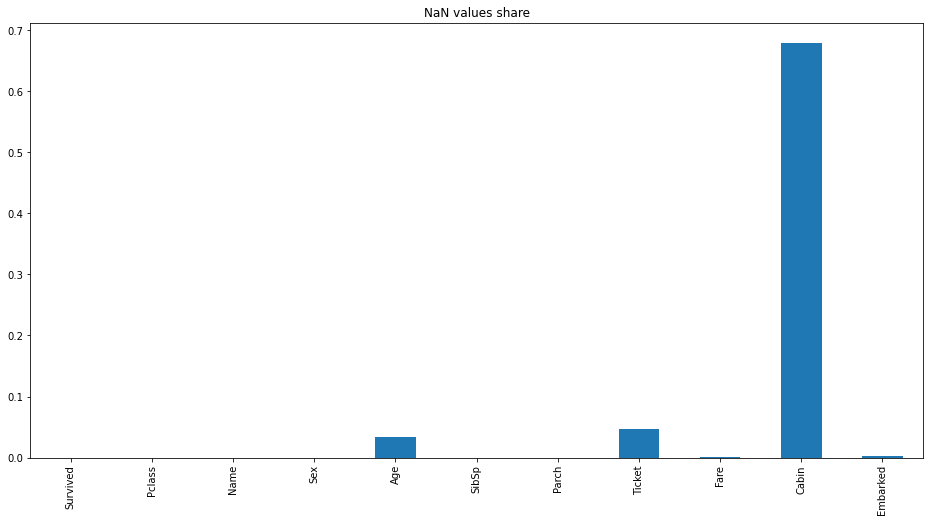

In [8]:
plt.figure(figsize=(16,8))
plt.title("NaN values share")
(data.isna().sum() / data.shape[0]).plot(kind='bar', stacked=True)
plt.show()

Most of Cabin values are lost. Let's introduce new category *'Unknown'* for missing values in the Cabin column. We will do the same for the Ticket column.

In [9]:
data['Ticket'].fillna('Unknown', inplace=True)
data['Cabin'].fillna('Unknown', inplace=True)

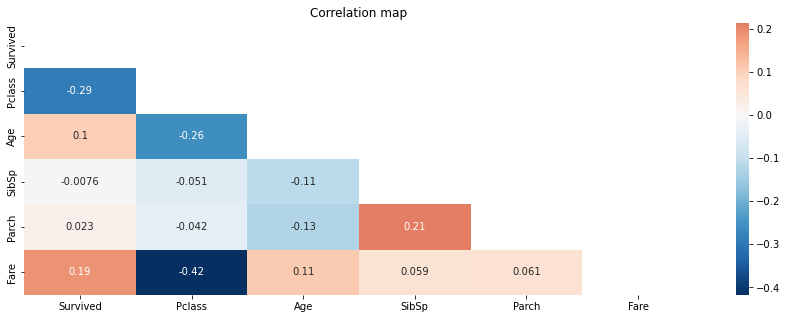

In [10]:
plt.figure(figsize=(15, 5))
mask = np.triu(np.ones_like(data.corr()))
sns.heatmap(data.corr(), cmap="RdBu_r", annot=True, center=0, mask=mask)
plt.title('Correlation map')
plt.show()

From the graph above we can see, that Pclass and Fare have negative correlation, thus the higher ticket class number the lower its fare. Let's fill NaN values for each ticket class with it's meadian value. 

In [11]:
medians = data.groupby('Pclass')['Fare'].median()
data['Fare'].fillna(data['Pclass'].map(medians), inplace=True)

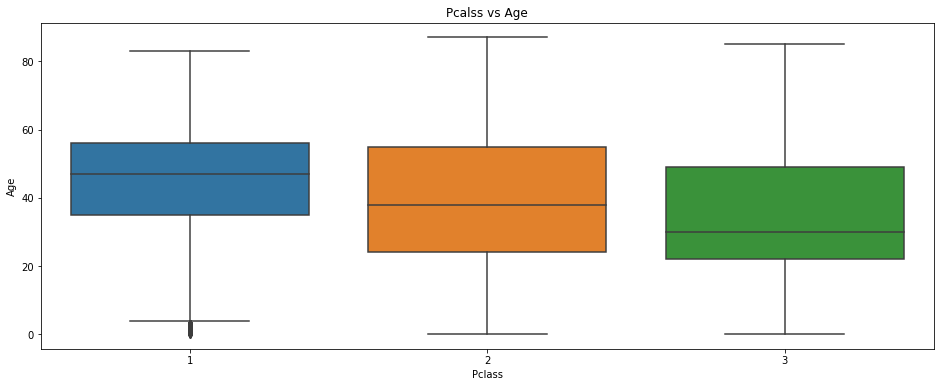

In [12]:
plt.figure(figsize=(16,6))
sns.boxplot(x=data.Pclass, y=data.Age)
plt.title('Pcalss vs Age')
plt.show()

Also we can notice that people with higher ticket class are tended to be older, this may mean that older people can afford more expensive tickets. Let's replace Age column NaNs with medians of each class.

In [13]:
medians = data.groupby('Pclass')['Age'].median()
data['Age'].fillna(data['Pclass'].map(medians), inplace=True)

Embarked column contains only 250 NaN values, let's replace them with mode.

In [14]:
data.Embarked = data.Embarked.fillna(data.Embarked.mode()[0])
data.isna().sum()

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Cabin       0
Embarked    0
dtype: int64

Boxplot below of initial distribution of fares for every ticket class shows a large number of outliers. We can remove by implementing the IQR method.

In [15]:
# plt.figure(figsize=(15,5))
# sns.boxplot(x=tidy.Pclass, y=tidy.Fare)
# plt.show()

In [16]:
# first_class, second_class, third_class = tidy[tidy.Pclass == 1], tidy[tidy.Pclass == 2], tidy[tidy.Pclass == 3]
# Q1, Q3 = first_class.Fare.quantile(0.25), first_class.Fare.quantile(0.75)
# IQR = Q3 - Q1
# tidy = tidy.drop(first_class.Fare[((first_class.Fare < (Q1-1.5*IQR)) | (first_class.Fare>(Q3+1.5*IQR)))].index)

# Q1, Q3 = second_class.Fare.quantile(0.25), second_class.Fare.quantile(0.75)
# IQR = Q3 - Q1
# tidy = tidy.drop(second_class.Fare[((second_class.Fare < (Q1-1.5*IQR)) | (second_class.Fare>(Q3+1.5*IQR)))].index)

# Q1, Q3 = third_class.Fare.quantile(0.25), third_class.Fare.quantile(0.75)
# IQR = Q3 - Q1
# tidy = tidy.drop(third_class.Fare[((third_class.Fare < (Q1-1.5*IQR)) | (third_class.Fare>(Q3+1.5*IQR)))].index)

In [17]:
# plt.figure(figsize=(15,5))
# sns.boxplot(x=tidy.Pclass, y=tidy.Fare)
# plt.show()

After we got rid of the outliers, we can start the analysis.

# Data exploration

In [18]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Survived,100000.0,0.427740,0.494753,0.00,0.00,0.00,1.0,1.00
Pclass,100000.0,2.106910,0.837727,1.00,1.00,2.00,3.0,3.00
Age,100000.0,38.319790,18.056272,0.08,25.00,38.00,53.0,87.00
SibSp,100000.0,0.397690,0.862566,0.00,0.00,0.00,1.0,8.00
Parch,100000.0,0.454560,0.950076,0.00,0.00,0.00,1.0,9.00
Fare,100000.0,43.911139,69.548710,0.68,10.04,24.45,33.5,744.66


1. The youngest passenger is 0.08 y/o and the oldest  is 87 y/o.
2. Max number of siblings/spouses is 8.
3. Max number of parents/children is 9.
4. The lowest fare is 0.68 and the highest is 744.66.

### Numeric variables: Age, SibSp, Parch, Fare

#### Age

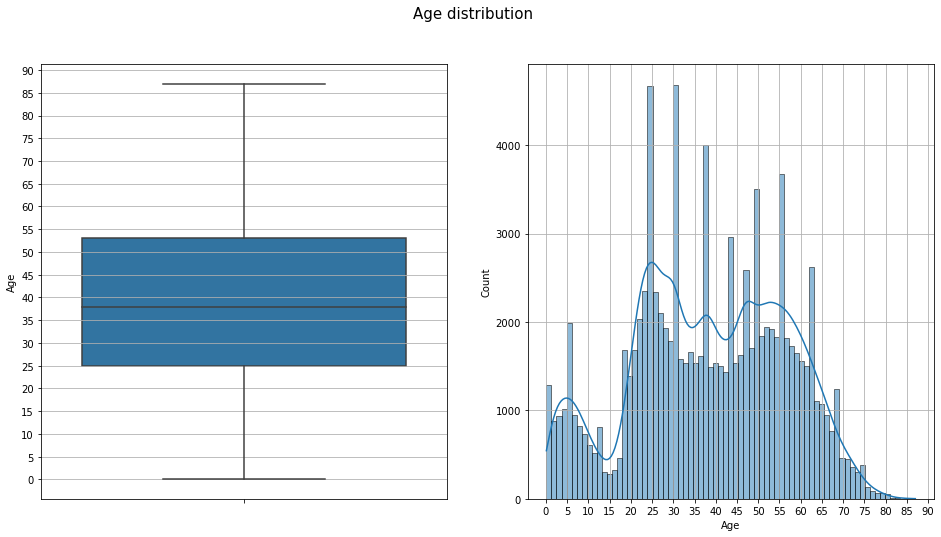

In [19]:
plot_numeric_variable(data.Age, 'Age distribution', scale_range=range(0, 100, 5))

Age distribution has 3 distinct peaks: around 5, 25, and 55 y/o. Let's create an "AgeGroup" variable with 3 categories.

In [20]:
bins = [0, 15, 40, 100]
labels = [1, 2, 3]
data['AgeGroup'] = pd.cut(data.Age, bins=bins, labels=labels, right=False)

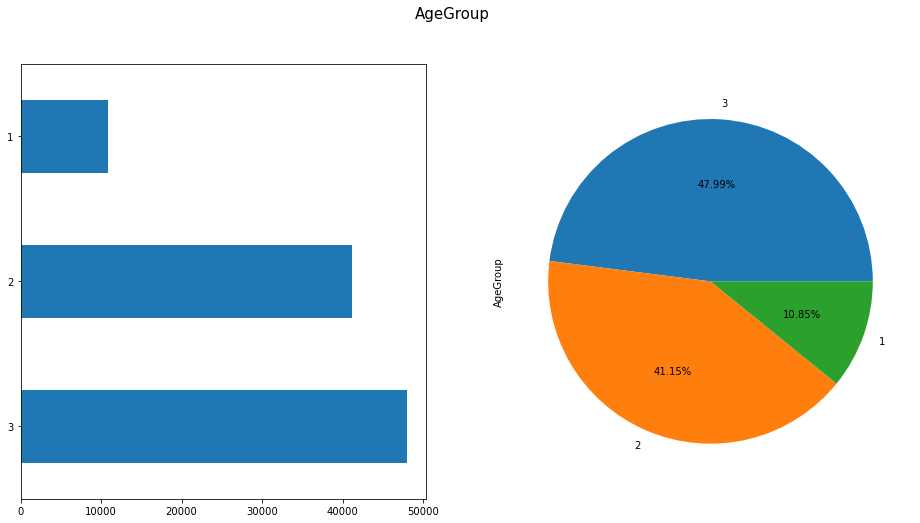

In [21]:
plot_categorical_variable(data.AgeGroup.value_counts(), 'AgeGroup')

#### SibSp

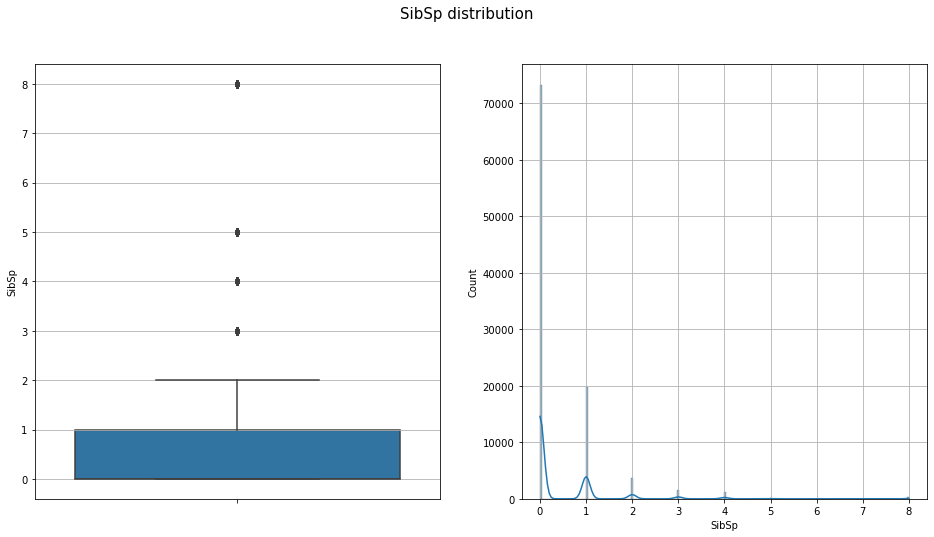

In [22]:
plot_numeric_variable(data.SibSp, 'SibSp distribution')

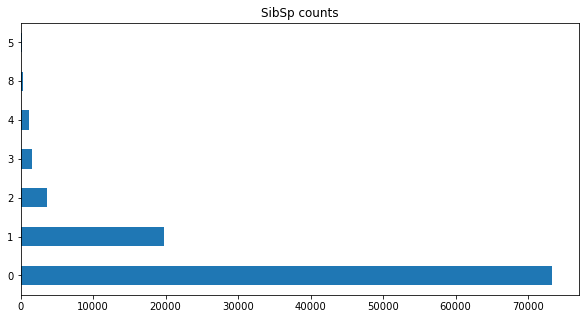

In [23]:
plt.title('SibSp counts')
data.SibSp.value_counts().plot(kind='barh', figsize=(10,5))
plt.show()

**Most of the passengers had neither siblings nor spouses on board**, and those with more than two could be considered exceptions. Let's group the outliers and introduce a new category.

In [24]:
data['ManySibSp'] = (data.SibSp > 2).astype('int8')

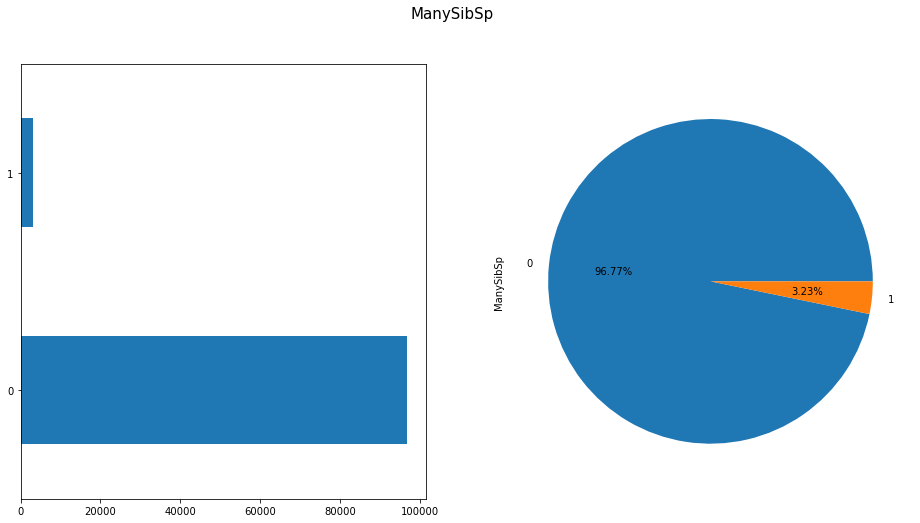

In [25]:
plot_categorical_variable(data.ManySibSp.value_counts(), 'ManySibSp')

#### ParCh

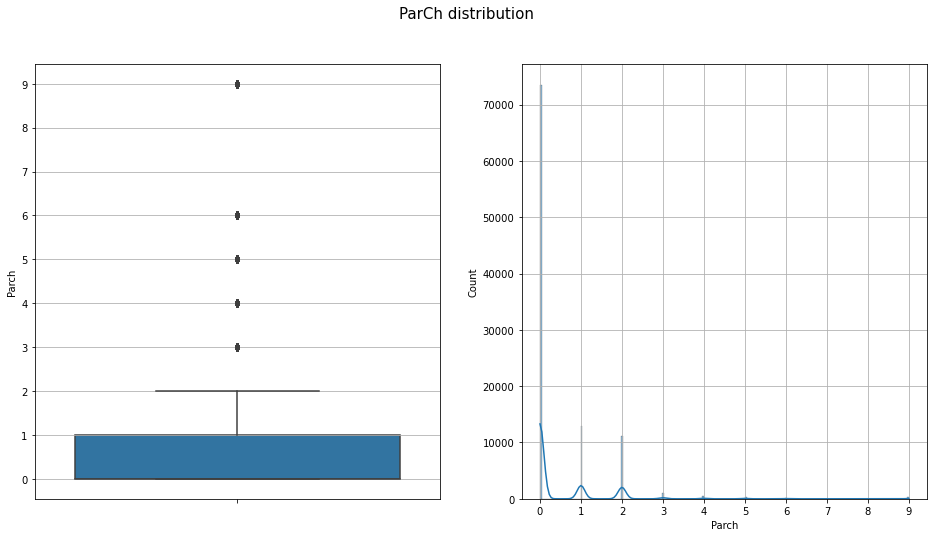

In [26]:
plot_numeric_variable(data.Parch, 'ParCh distribution', scale_range=range(0,10))

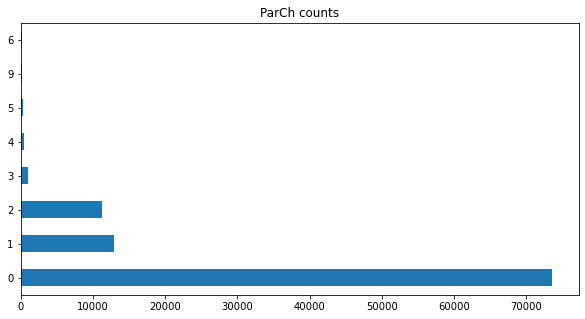

In [27]:
plt.title('ParCh counts')
data.Parch.value_counts().plot(kind='barh', figsize=(10,5))
plt.show()

As with the SibSp variable, **most passengers had neither parents nor children on board**, and those with more than two are rather an exception. For this parameter, we are also going to group the outliers and introduce a new category.

In [28]:
data['ManyParCh'] = (data.Parch > 2).astype('int8')

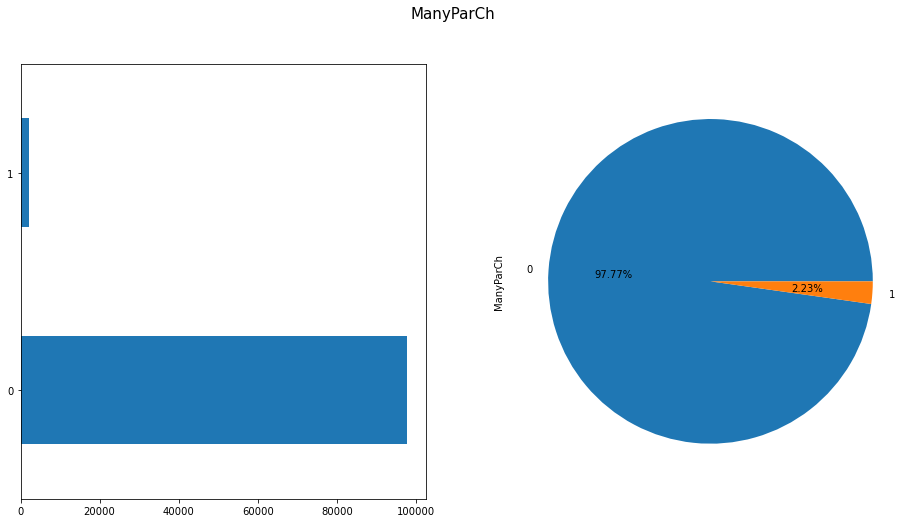

In [29]:
plot_categorical_variable(data.ManyParCh.value_counts(), 'ManyParCh')

Since SibSp and ParCh are relatives on board, we can create a new variable representing the total number of relatives on board.

In [30]:
data['Relatives'] = data['SibSp'] + data['Parch']

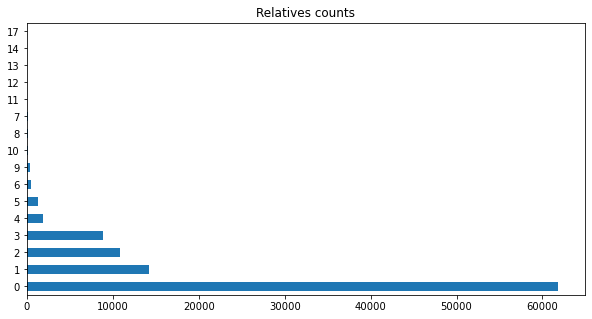

In [31]:
plt.title('Relatives counts')
data.Relatives.value_counts().plot(kind='barh', figsize=(10,5))
plt.show()

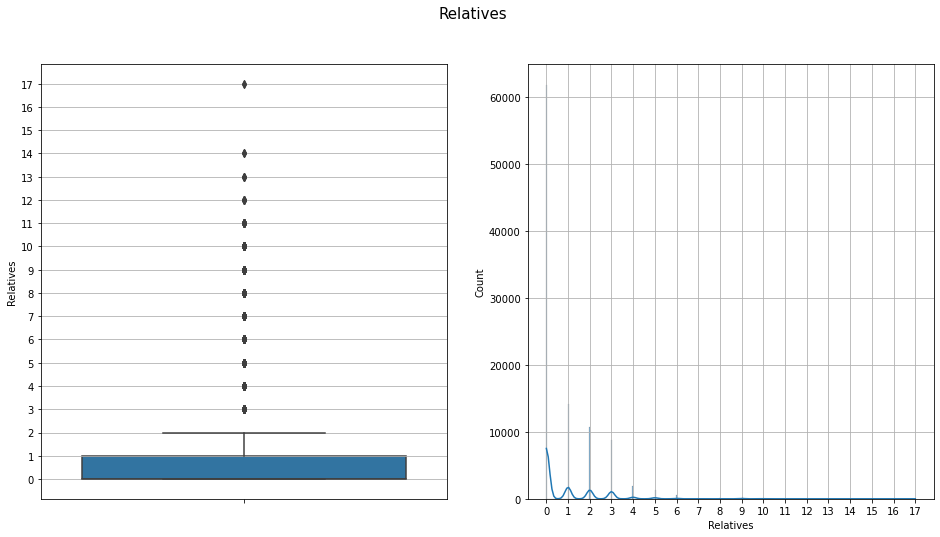

In [32]:
plot_numeric_variable(data.Relatives, 'Relatives', scale_range=range(20))

We can now conclude that **most people traveled alone** and introduce variable representing whether a passenger had many relatives on board.

In [33]:
data['ManyRelatives'] = (data.Parch > 2).astype('int8')

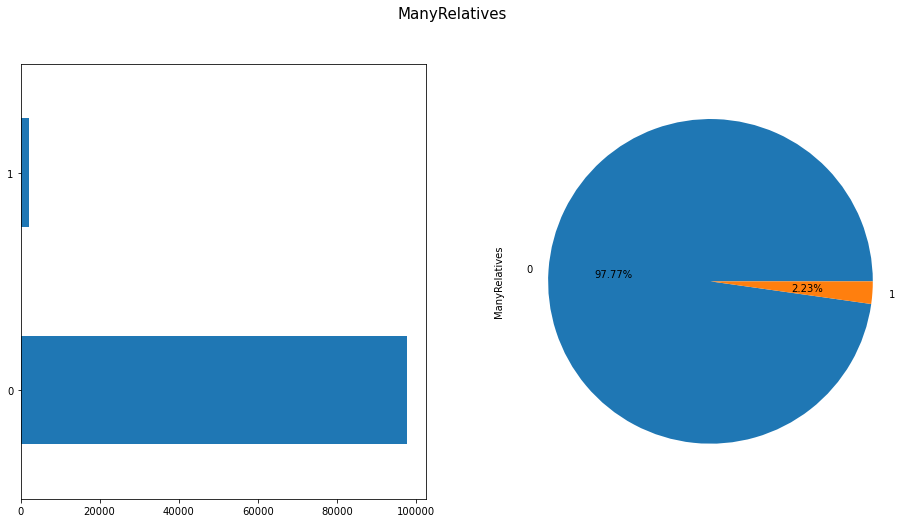

In [34]:
plot_categorical_variable(data.ManyRelatives.value_counts(), 'ManyRelatives')

#### Fare

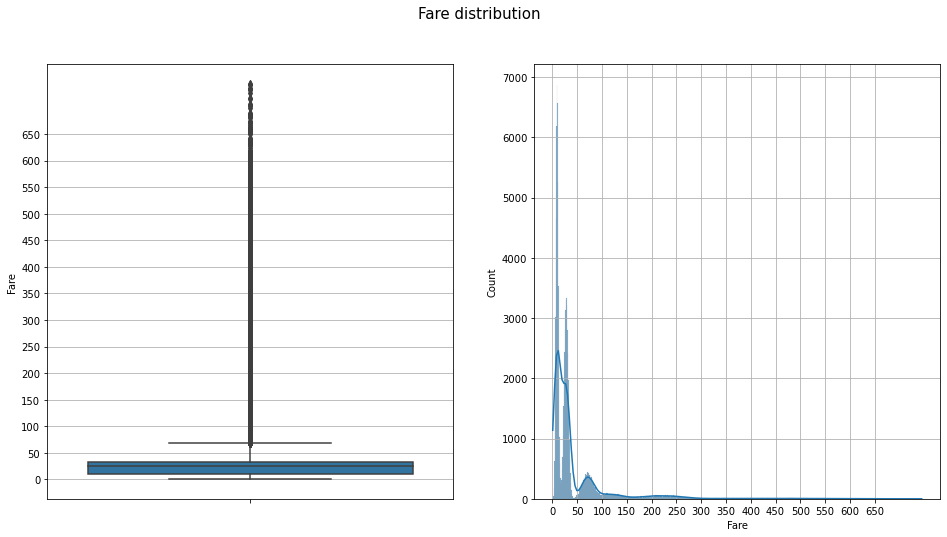

In [35]:
plot_numeric_variable(data.Fare, 'Fare distribution', scale_range=range(0, 700, 50))

There are a lot of outliers. Let's create a variable and group them into a separate category.

In [36]:
data['LargeFare'] = (data.Fare > 80).astype('int8')

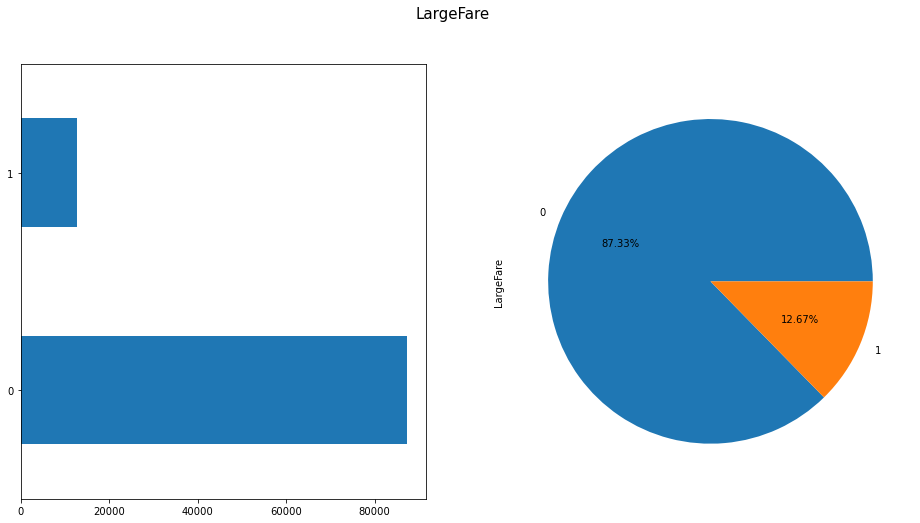

In [37]:
plot_categorical_variable(data.LargeFare.value_counts(), 'LargeFare')

### Categorical variables: Survived, Pclass, Name, Sex, Ticket, Cabin, Embarked

#### Survived

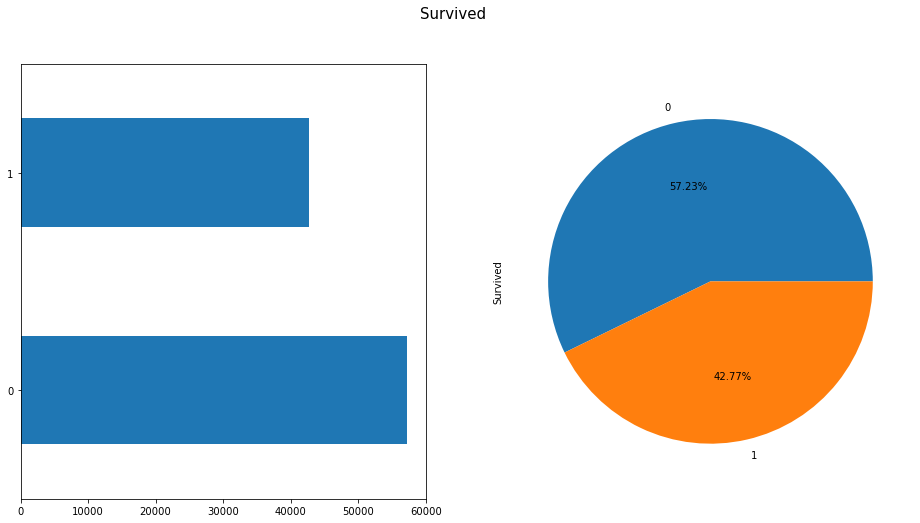

In [38]:
plot_categorical_variable(data.Survived.value_counts(), 'Survived')

**Only 42.77% of the passengers survived**, which is logical because, according to historical facts, the ship had only 20 lifeboats that could only accommodate half of the people on board, and due to panic and disorganization, many lifeboats carried only half of their maximum capacity.

#### Pclass

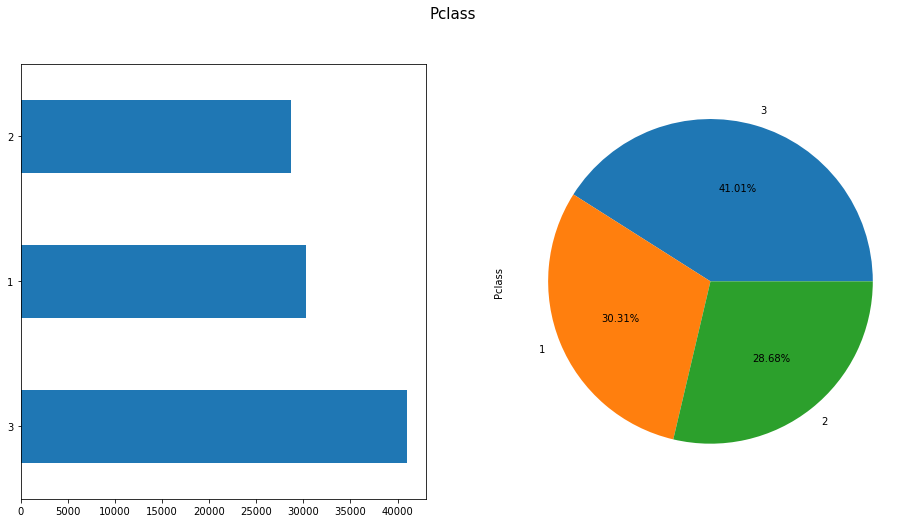

In [39]:
plot_categorical_variable(data.Pclass.value_counts(), 'Pclass')

**Most passengers traveled in 3rd class.**

#### Name

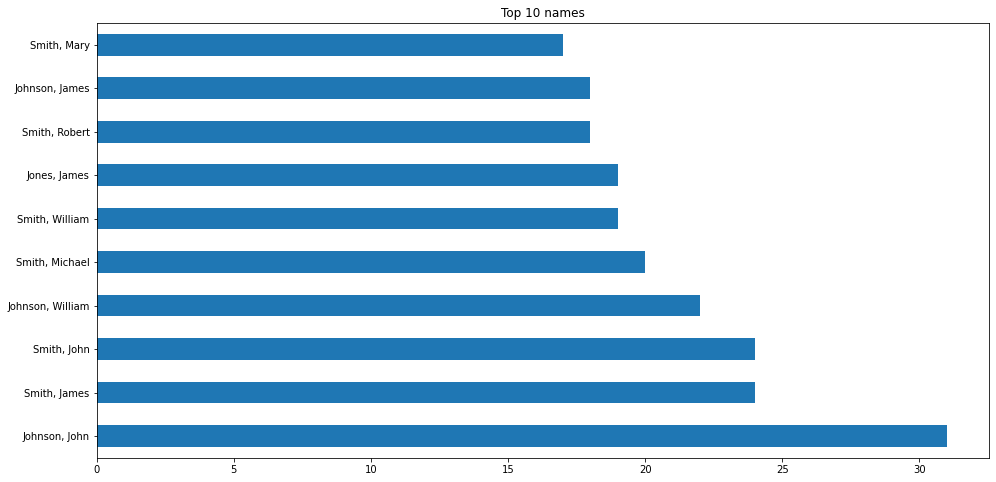

In [40]:
data.Name.value_counts()[:10].plot(figsize=(16,8), kind='barh', title='Top 10 names')
plt.show()

In [41]:
duplicated_name = data.Name.value_counts()[data.Name.value_counts() > 1].index
number_of_dups = 0
for name in duplicated_name:
    number_of_dups += data[data.Name == name].duplicated().sum()
print(number_of_dups)

0


There are no duplicated rows having the same name.

#### Sex

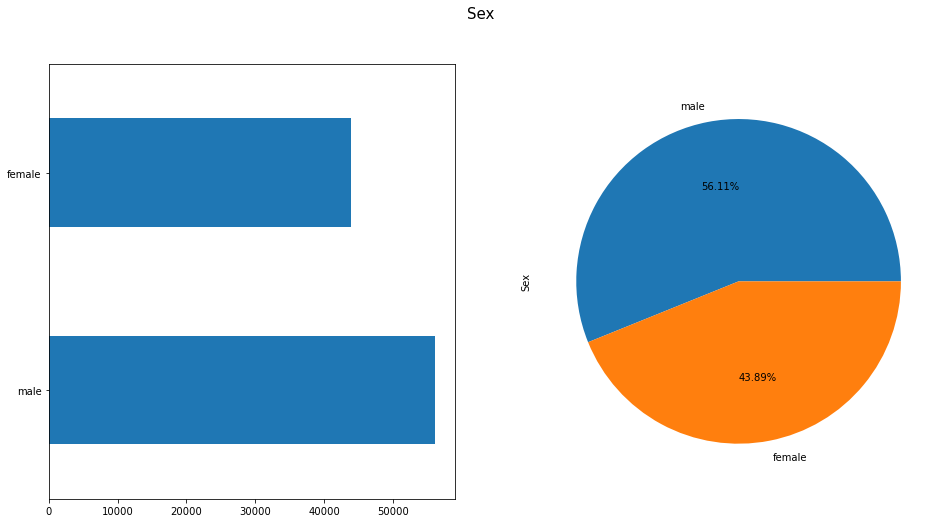

In [42]:
plot_categorical_variable(data.Sex.value_counts(), 'Sex')

**Most of the passengers were male.**

#### Ticket

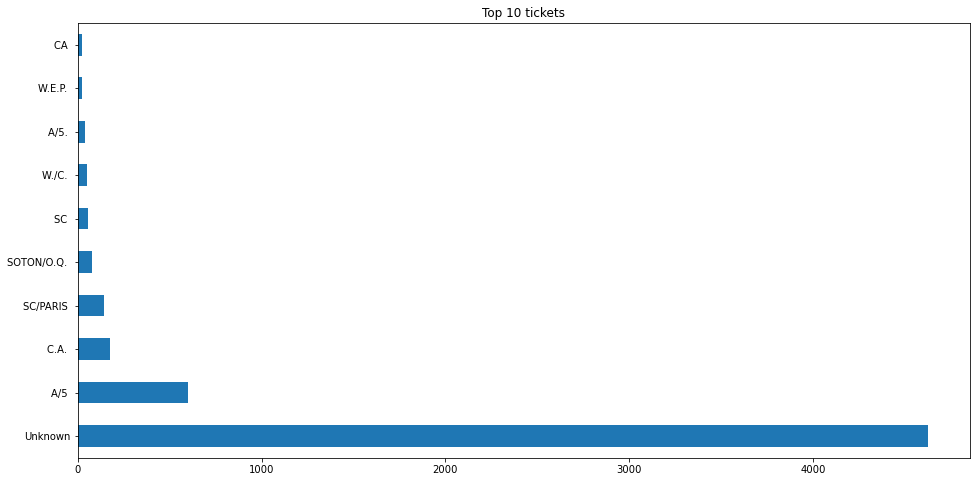

In [43]:
data.Ticket.value_counts()[:10].plot(figsize=(16,8), kind='barh', title='Top 10 tickets')
plt.show()

Most of the ticket numbers are unknown, but some of the passengers had the same ticket. It is possible that children with nannies or some passengers with relatives on board had the same ticket. Let's create a variable to tell if a passenger had the same ticket number as someone else.

In [44]:
def has_same_value(value, values):
    if value in values:
        return 1
    return 0

In [45]:
duplicated_ticket = data.Ticket.value_counts()[data.Ticket.value_counts() > 1].index[1:]
data['SameTicket'] = data.apply(lambda x: has_same_value(x.Ticket, duplicated_ticket), axis=1)

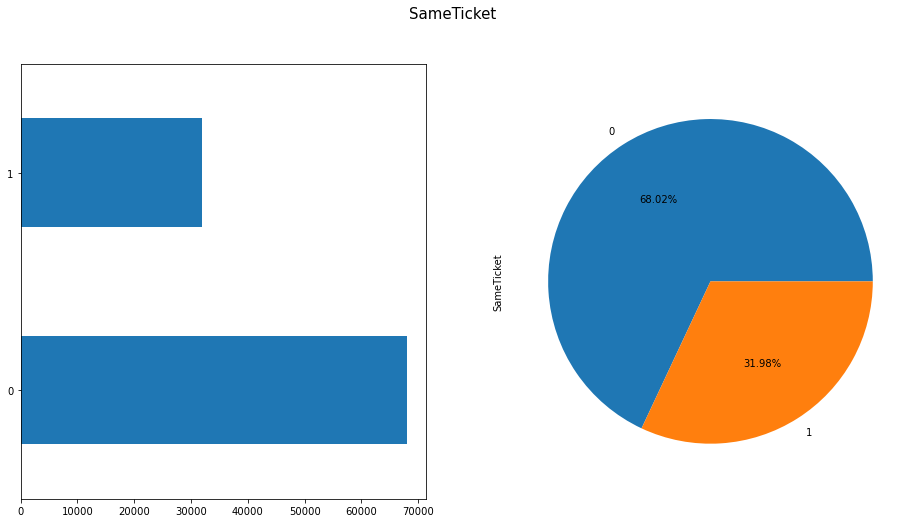

In [46]:
plot_categorical_variable(data.SameTicket.value_counts(), 'SameTicket')

#### Cabin

Historical documents state that the letter at the beginning of the cabin number indicates the deck level of the cabin. Let's create a "Deck" variable. Values "U" will stand for "Unknown".

In [47]:
data['Deck'] = data.Cabin.str[0]

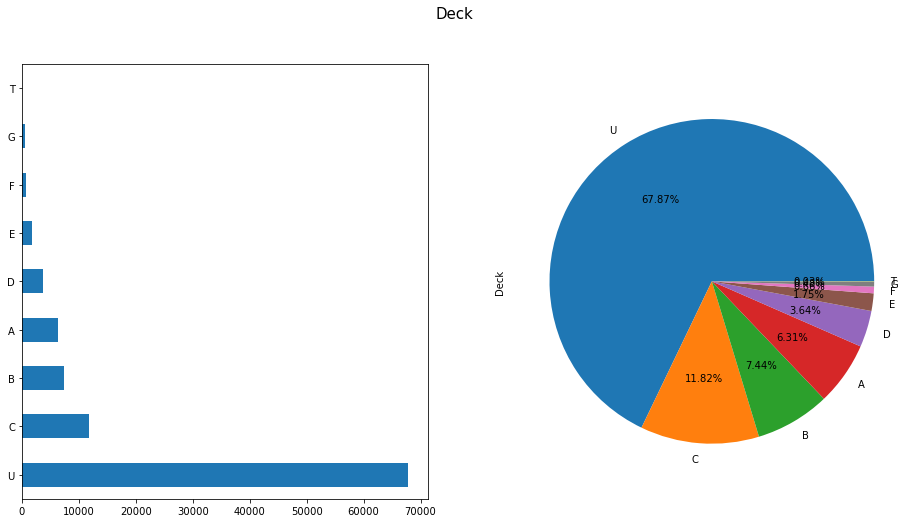

In [48]:
plot_categorical_variable(data.Deck.value_counts(), 'Deck')

#### Embarked

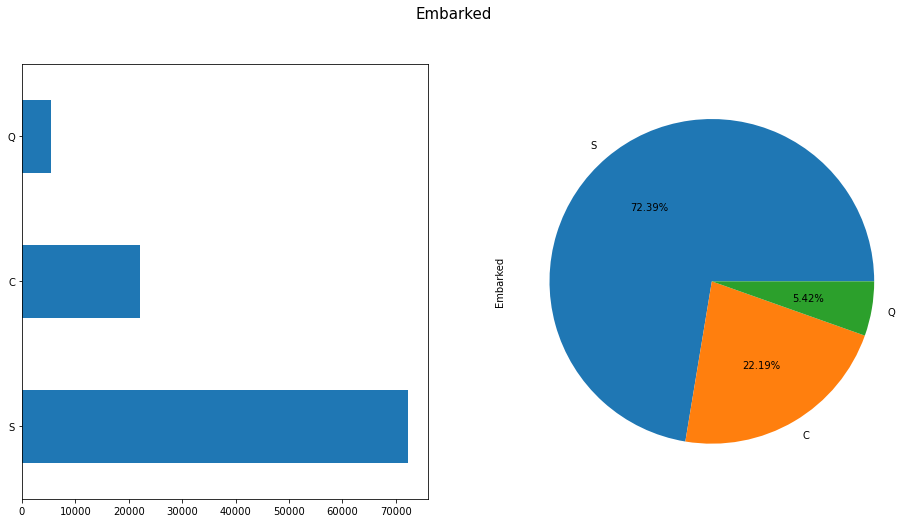

In [49]:
plot_categorical_variable(data.Embarked.value_counts(), 'Embarked')

**Most of the passengers embarked at Southampton**.

### First observations

- Only 42.77% of the passengers survived
- Most of the passengers had no relatives on board
- Most passengers traveled in 3rd class, which were the cheapest.
- 56% of passengers were male
- 72,4% embarked at Southampton, 22,2% at Cherbourg and only 5,4% at Queenstown.

Now let's look at the relationships between the variables.

### Relationships exploration

First, let's get rid of columns Name, Ticket, Cabin that do not seem usefull anymore.

In [61]:
data.drop(['Name', 'Ticket', 'Cabin'], inplace=True, axis=1)

In [63]:
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,AgeGroup,ManySibSp,ManyParCh,Relatives,ManyRelatives,LargeFare,SameTicket,Deck
PassengerId,,,,,,,,,,,,,,,,
0,1,1,male,47.00,2,0,27.14,S,3,0,0,2,0,0,0,C
1,0,3,male,30.00,0,0,13.35,S,2,0,0,0,0,0,1,U
2,0,3,male,0.33,1,2,71.29,S,1,0,0,3,0,0,0,U
3,0,3,male,19.00,0,0,13.04,S,2,0,0,0,0,0,0,U
4,1,3,male,25.00,0,0,7.76,S,2,0,0,0,0,0,0,U


In [164]:
target = 'Survived'
numeric_features = ['Age', 'SibSp', 'Parch', 'Fare', 'Relatives']
categorical_features = [
    'Pclass',
    'Sex',
    'Embarked',
    'AgeGroup',
    'ManySibSp',
    'ManyParCh',
    'ManyRelatives',
    'LargeFare',
    'SameTicket',
    'Deck'
]

#### Numeric variables X target variable

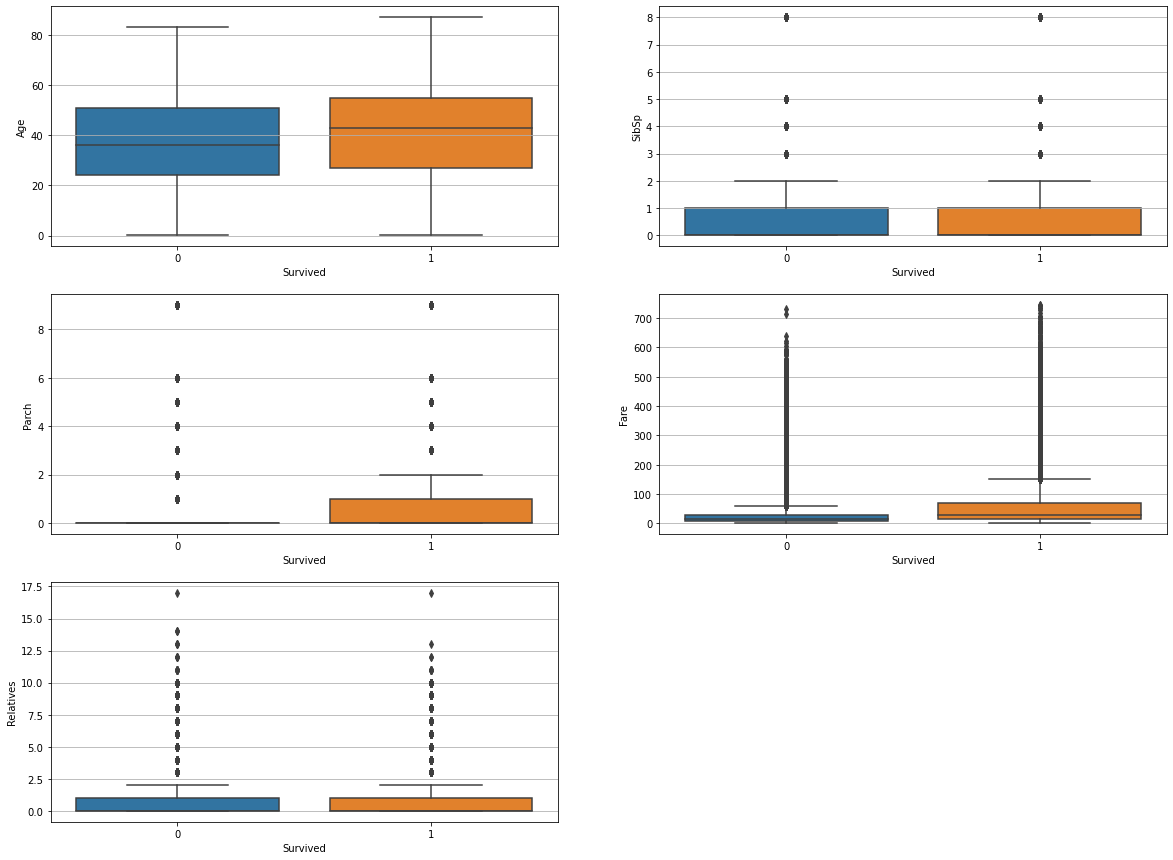

In [210]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 15))
for idx, feature in  enumerate(numeric_features):
    axes[idx // 2, idx % 2].grid()
    sns.boxplot(y=feature, x=target, data=data, ax=axes[idx // 2, idx % 2])
fig.delaxes(axes[2][1])

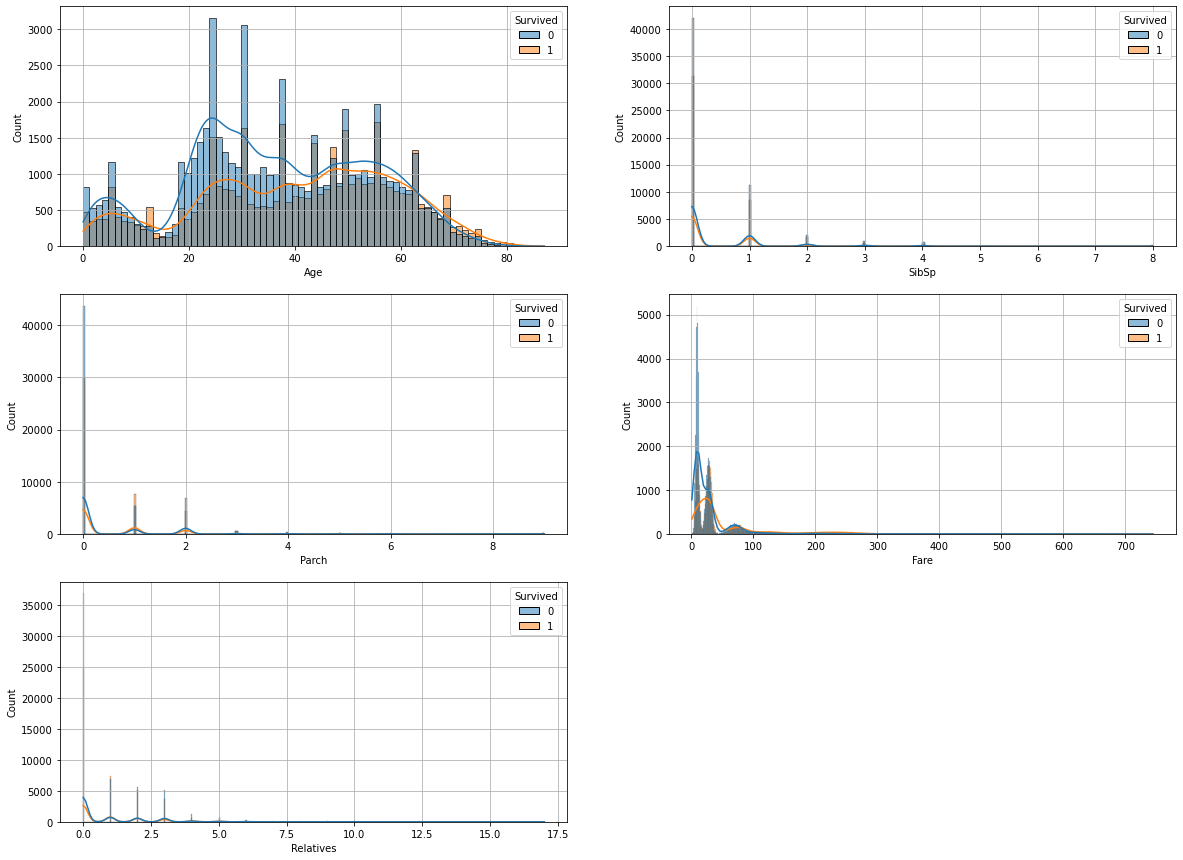

In [211]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 15))
for idx, feature in  enumerate(numeric_features):
    axes[idx // 2, idx % 2].grid()
    sns.histplot(x=feature, hue=target, data=data, ax=axes[idx // 2, idx % 2], kde=True)
fig.delaxes(axes[2][1])

**Observations**:
1. The destributions of Age for survived/not survived people slightly differ.
2. The median fare and its distribution have a large variance for surviving passengers.
3. The survived passengers have larger variance in the Parents/Children variable, while the majority of the died passengers had neither parents nor children.

#### Categorical variables X target variable

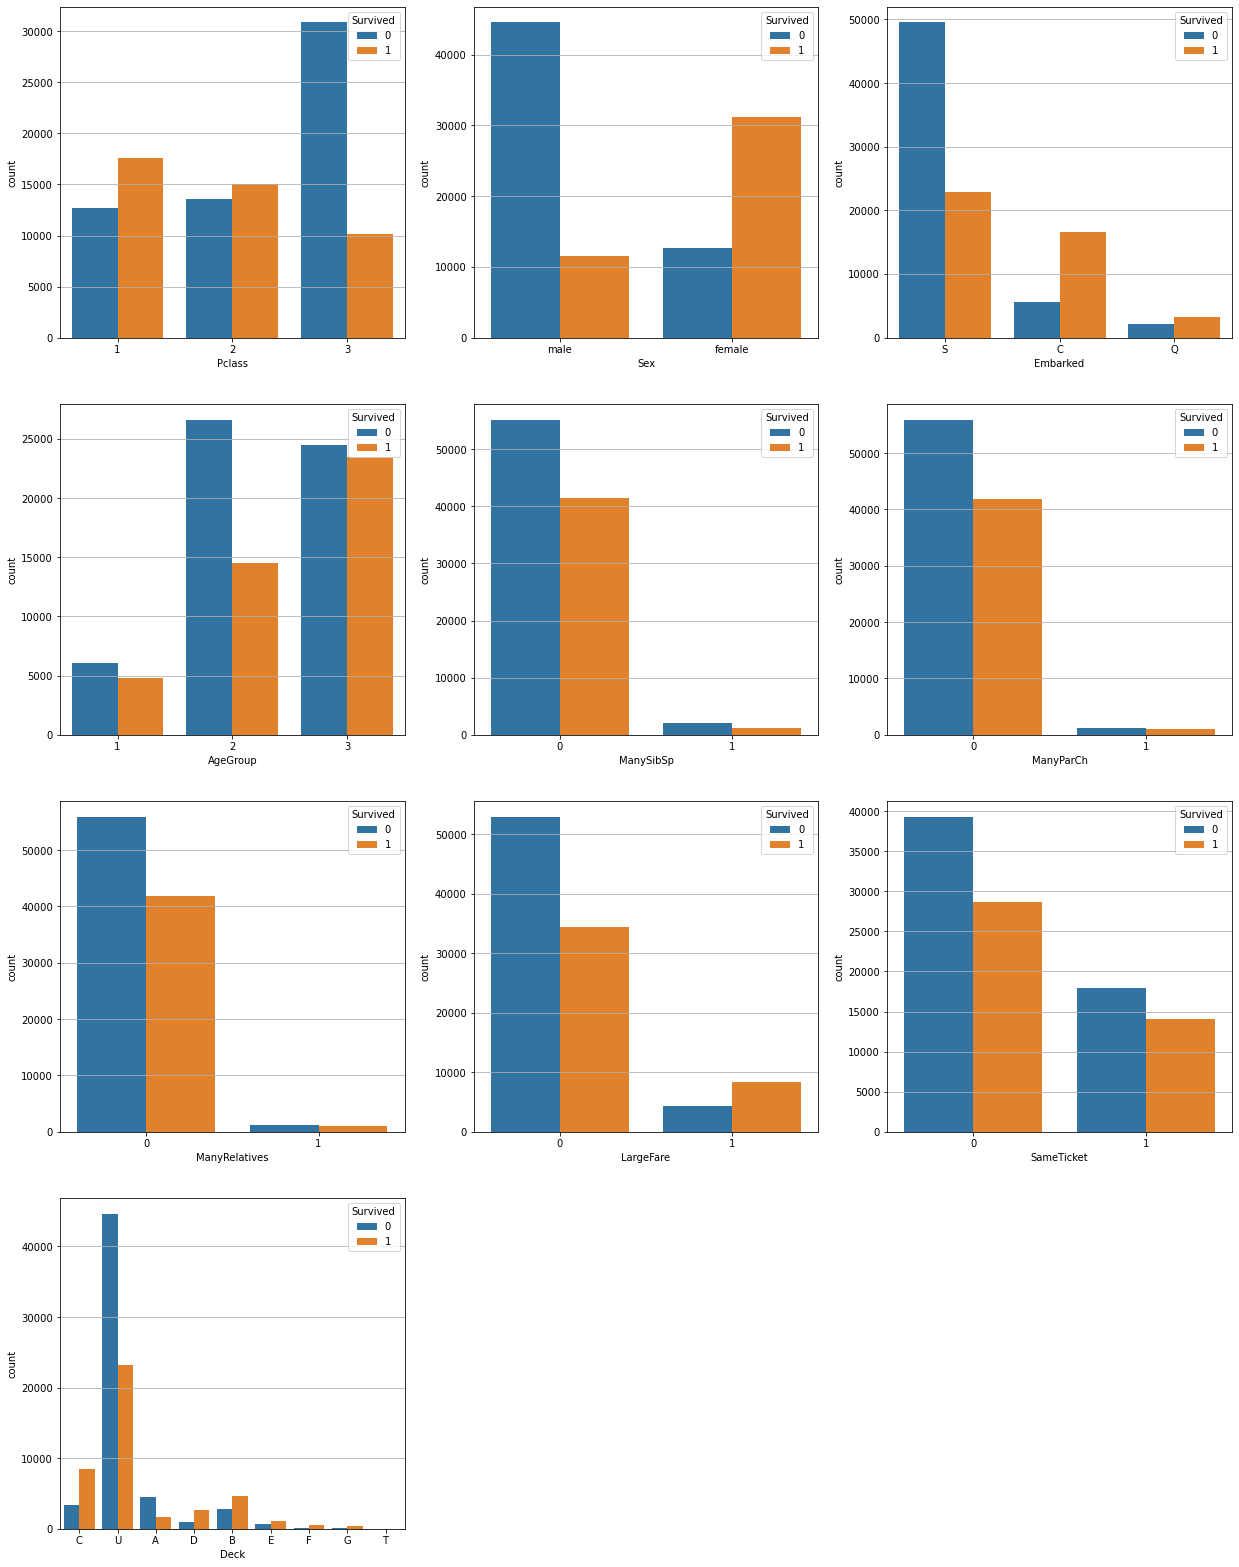

In [213]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(21, 28))

for idx, feature in  enumerate(categorical_features):
    axes[idx // 3, idx % 3].grid()
    sns.countplot(x=feature, hue=target, data=data, ax=axes[idx // 3, idx % 3])
fig.delaxes(axes[3][1])
fig.delaxes(axes[3][2])

**Observations:**
1. More than half of the 1st and 2nd class passengers managed to survive, the 3rd class passengers have much less chance of surviving.
2. There are more than twice as many survived passengers among females than those who died. There are about 4 times more male who died than those who survived.
3. Most passengers who embarked at Cherbourg and Queenstown survived. More than 5/6 of the died passengers embarked at Southampton.
4. Passengers of the 2nd age group (14-40 y/o) were less likely to survive, while the chances of other groups were almost equal.
5. Passengers with more relatives on board were more likely to survive.
6. Passengers with higher fares survived more often than passengers with cheaper fares.
7. Passengers on "A" deck and those with an unknown deck were less likely to survive. Passengers who traveled on other decks had greater chance to survive than to die.
7. Passengers from C Cabin_section has the best chances to survive.
8. the fraction of survived children and adults >40 is bigger than fraction of survived Adults_18_40
9. The fraction of survived passengers with unknown Cabin is less than fraction with given information about Cabin

In [51]:
# tidy_plot = tidy.groupby(['Survived', 'Pclass']).size().reset_index().pivot(columns='Survived', index='Pclass', values=0)
# tidy_plot.plot(kind='bar', stacked=True, figsize=(15,6))
# plt.title('Age vs Survival')
# plt.show()

There's quite strong correlation between ticket class and survivability. **People with tickets of 1st and 2nd class more likely to survive** 

In [52]:
# tidy_plot = tidy.groupby(['Survived', 'Sex']).size().reset_index().pivot(columns='Survived', index='Sex', values=0)
# tidy_plot.plot(kind='bar', stacked=True, figsize=(15,6))
# plt.title('Sex vs Survival')
# plt.show()

**Women in general have a very high chance of survival compared to men.**

In [53]:
# bins=[0,21,41,61,81,100]
# labels = ['0-20','21-40','41-60','61-80','81-100']
# tidy = data.copy(
# )
# tidy['AgeGroup2'] = pd.cut(tidy.Age, bins=bins, labels=labels, right=False)

# tidy_plot = tidy.groupby(['Survived', 'AgeGroup2']).size().reset_index().pivot(columns='Survived', index='AgeGroup2', values=0)
# tidy_plot.plot(kind='bar', stacked=True, figsize=(15,6))
# plt.title('Age vs survival')
# plt.show()

We grouped ages into a few bins. As plot shows, **there is no strong correlation between age and chance to survive in general** except for 61-80 group, but we can explain this by the fact that older people tend to travel with tickets of higher class.

Let's look how ticket class, gender and age of its owner affect chances to survive.

In [54]:
# sns.catplot(x='AgeGroup', col='Sex', row='Pclass', hue='Survived', data=tidy, kind='count')

**Older female and male people in 1st class are more likely to survive**. Male people in 3rd class have the lowest chance to survive**

Now let's look if number of relatives on board affect changes to survive.

In [55]:
# tidy_plot = tidy.groupby(['Survived', 'Relatives']).size().reset_index().pivot(columns=['Survived'], index='Relatives', values=0)
# tidy_plot.plot(kind='bar', figsize=(15,6))
# plt.title('Number of relatives vs Survival')
# plt.show()

The plot above shows that people without any relatives and big families are less likely to survive. Let's add Sex of a person to the plot.

In [56]:
# sns.catplot(x='Relatives', col='Sex', hue='Survived', data=tidy, kind='count')

The absence or small number of relatives provides a higher chance of survival for women. Now find out if ticket class has affect.

In [57]:
# sns.catplot(x='Relatives', col='Sex', row='Pclass', hue='Survived', data=tidy, kind='count')

**Women in 3rd class with high number of relatives are less likely to survive.**

In [58]:
# sns.catplot(x='Embarked', col='Sex', row='Pclass', hue='Survived', data=tidy, kind='count')

People who embarked in Cherbourg and Queenstown are more likely to survive.

In [59]:
# sns.catplot(x='Sex', col='Pclass', hue='Survived', data=tidy, kind='count')

# Summary

We processed the data: filled in the gaps, did some "sanity checks", got rid off outliers in Fare column, and added the AgeGroup and Relatives attributes, which simplified the analysis.

We identified a few patterns in the data:
- People with tickets of 1st and 2nd class more likely to survive, male in 3rd class have the least chance to survive
- Women in general have a very high chance of survival compared to men
- There is no strong correlation between age and chance to survive in general, but older people in 1st class are more likely to survive
- The absence or small number of relatives provides a higher chance of survival for women
- Women in 3rd class with high number of relatives are less likely to survive
- People who embarked in Cherbourg and Queenstown throughout all ticket classes and genders are more likely to survive.